In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas
from scipy.stats import gmean
import simexpal
import yaml

In [3]:
cfg = simexpal.config_for_dir()

raw_data = []
for run, f in cfg.collect_successful_results():
    suffix = ''
    if run.experiment.revision.name == 'all-scores':
        continue
    if run.instance.shortname.startswith('hyperbolic') or run.instance.shortname.startswith('rmat'):
        continue
    if run.experiment.name.startswith('t'):
        continue
    if run.experiment.name.endswith('x2'):
        suffix = '-x2'
    yml = yaml.load(f, Loader=yaml.SafeLoader)
    exp = run.experiment.revision.name
    raw_data.append({
        'exp': exp + suffix,
        'inst': run.instance.shortname,
        'n': yml['num_nodes'],
        'm': yml['num_edges'],
        'procs': yml['num_procs'] / (2 if suffix == '-x2' else 1),
        'time': yml['time'],
        'time_diam': yml.get('mtime_diam', 0) / 1000,
        'time_phase1': yml.get('mtime_phase1', 0) / 1000,
        'time_phase2': yml.get('mtime_phase2', 0) / 1000,
        'time_transition': yml.get('mtime_transition', 0) / 1000,
        'time_barrier': yml.get('mtime_barrier', 0) / 1000,
        'time_reduce': yml.get('mtime_reduce', 0) / 1000,
        'time_check': yml.get('mtime_reduce', 0) / 1000,
        'epochs': yml['num_epochs'] + 1,
        'samples': yml['num_samples']
    })
raw_df = pandas.DataFrame(raw_data)

simexpal: Using pure Python YAML parser. Installing libyaml will improve performance.


Skipping failed run n16x2/friendster.tf[0]


In [4]:
# Post-process the dataframe.

# Join with baseline.
baseline_df = raw_df[(raw_df['exp'] == 'optI-insights') & (raw_df['procs'] == 1)].set_index(['inst'])
df = raw_df.join(baseline_df[['time', 'time_phase1', 'time_phase2']], on=['inst'], rsuffix='_bl')

# Compute speedups.
df['time_su'] = df['time_bl'] / df['time']
df['time_phase1_su'] = df['time_phase1_bl'] / df['time_phase1']
df['time_phase2_su'] = df['time_phase2_bl'] / df['time_phase2']

In [4]:
summary_df = df.groupby(['exp', 'procs']).agg(gmean)
summary_df['time_per_sample'] = summary_df['time'] / summary_df['samples'] * 1000000
summary_df

/home/grintena/.local/lib/python3.6/site-packages/scipy/stats/stats.py:324: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(np.array(a, dtype=dtype))


epochs       samples         time  time_barrier  \
exp            procs                                                        
initial        1.0    525.716376  1.390380e+06  2863.850820           0.0   
               2.0     80.868817  1.587360e+06  1897.390769           0.0   
               4.0     19.246688  1.717350e+06  1299.196951           0.0   
               8.0      5.229053  1.964948e+06  1012.141425           0.0   
               16.0     2.638828  4.064916e+06  1054.204253           0.0   
...                          ...           ...          ...           ...   
shorter-epochs 1.0    565.814876  1.507941e+06  3104.051906           0.0   
               2.0     84.174103  1.539351e+06  1881.819204           0.0   
               4.0     18.868049  1.638726e+06  1237.284728           0.0   
               8.0      6.192646  2.294950e+06  1079.404672           0.0   
               16.0     2.938096  4.450452e+06  1076.020361           0.0   

                          time_bl  time_check  time_diam  time_phase1  \
exp            procs                                                    
initial        1.0    2586.475377         0.0        0.0          0.0   
               2.0    2586.475377         0.0        0.0          0.0   
               4.0    2586.475377         0.0        0.0          0.0   
               8.0    2586.475377         0.0        0.0          0.0   
               16.0   2586.475377         0.0        0.0          0.0   
...                           ...         ...        ...          ...   
shorter-epochs 1.0    2586.475377         0.0        0.0          0.0   
               2.0    2586.475377         0.0        0.0          0.0   
               4.0    2586.475377         0.0        0.0          0.0   
               8.0    2586.475377         0.0        0.0          0.0   
               16.0   2586.475377         0.0        0.0          0.0   

                      time_phase1_bl  time_phase1_su  time_phase2  \
exp            procs                                                
initial        1.0        162.669476             inf          0.0   
               2.0        162.669476             inf          0.0   
               4.0        162.669476             inf          0.0   
               8.0        162.669476             inf          0.0   
               16.0       162.669476             inf          0.0   
...                              ...             ...          ...   
shorter-epochs 1.0        162.669476             inf          0.0   
               2.0        162.669476             inf          0.0   
               4.0        162.669476             inf          0.0   
               8.0        162.669476             inf          0.0   
               16.0       162.669476             inf          0.0   

                      time_phase2_bl  time_phase2_su  time_reduce   time_su  \
exp            procs                                                          
initial        1.0       2087.874545             inf          0.0  0.903146   
               2.0       2087.874545             inf          0.0  1.363175   
               4.0       2087.874545             inf          0.0  1.990826   
               8.0       2087.874545             inf          0.0  2.555449   
               16.0      2087.874545             inf          0.0  2.453486   
...                              ...             ...          ...       ...   
shorter-epochs 1.0       2087.874545             inf          0.0  0.833258   
               2.0       2087.874545             inf          0.0  1.374455   
               4.0       2087.874545             inf          0.0  2.090445   
               8.0       2087.874545             inf          0.0  2.396205   
               16.0      2087.874545             inf          0.0  2.403742   

                      time_transition  time_per_sample  
exp            procs                                    
initial        1.0                

In [27]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 7}

matplotlib.rc('font', **font)

default_xsize = 1.5

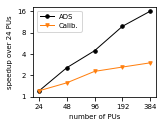

In [32]:
xsize = 2.2
ysize = xsize * 0.75

exps = ['optB-blocking-x2']

#algname = {
#    'optI-blocking-x2': 'TODO',
#    'optI-hybrid-x2': 'TODO',
#    'optI-reduction-x2': 'TODO',
#}

plot_df = df.groupby(['exp', 'procs']).agg({'time_phase2_su': gmean, 'time_phase1_su': gmean})

fig, ax = plt.subplots()
fig.set_size_inches(xsize, ysize)
plt.xlabel('number of PUs')
plt.ylabel('speedup over 24 PUs')
ncores = [n * 24 for n in [1, 2, 4, 8, 16]]
for e in exps:
    plt.loglog(ncores, plot_df.loc[e]['time_phase2_su'], label='ADS', color='black', marker='o', linewidth=1, markersize=3.5)
    plt.loglog(ncores, plot_df.loc[e]['time_phase1_su'], label='Calib.', color='C1', marker='v', linewidth=1, markersize=3.5)
plt.xticks(ncores)
plt.yticks([1, 2, 4, 8, 16])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.minorticks_off()
#plt.grid()
plt.legend()
plt.savefig('gen/real-phase-su.pdf', format='pdf', bbox_inches = 'tight')
plt.show()